In [1]:
import wget
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

**Dataset**

In [4]:
wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

100% [..........................................................................] 1423529 / 1423529

'housing.csv'

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value')

**EDA**

 * Load the data

In [6]:
data= pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Q: Look at the median_house_value variable. Does it have a long tail?** 
* A: it is a right-skewer distribution (tail is on the right)

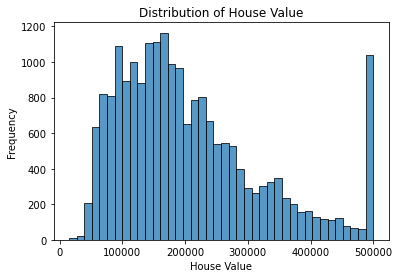

In [8]:
sns.histplot(data.median_house_value, bins=40)
plt.ylabel('Frequency')
plt.xlabel('House Value')
plt.title('Distribution of House Value')
plt.show()

**Features**

'latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value'

In [9]:
data= data[['latitude', 'longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income', 'median_house_value']]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            20640 non-null  float64
 1   longitude           20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


# Question 

Find a feature with missing values. How many missing values does it have?

In [15]:
data_miss= data.isnull().sum()
data_miss

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [16]:
print(f'The total missing value is {data_miss.iloc[4]}')

The total missing value is 207


# Question

What's the median (50% percentile) for variable 'population'?

In [17]:
data_median = np.median(data['population'])
data_median

1166.0

**Split the data**

* Shuffle the initial dataset, use seed 42
* Split your data in train/val/test sets, with 60%/20%/20% distribution
* Make sure that the target value ('median_house_value') is not in your dataframe
* Apply the log transformation to the median_house_value variable using the np.log1p() function

In [19]:
np.random.seed(42)
n = len(data)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

data_shuffle = data.iloc[idx]

df_train = data_shuffle.iloc[:n_train].copy()
df_test   = data_shuffle.iloc[n_train:n_train+n_test].copy()
df_val  = data_shuffle.iloc[n_train+n_test:].copy()

#creates an array to preserve original target variable data

y_train_orig = df_train.median_house_value.values 
y_val_orig   = df_val.median_house_value.values
y_test_orig  = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val   = np.log1p(df_val.median_house_value.values)
y_test  = np.log1p(df_test.median_house_value.values)

# Question

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [21]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [22]:
train_total_bedrooms_mean = df_train['total_bedrooms'].mean()
train_total_bedrooms_mean

533.4803317730147

In [23]:
X_train_filled_mean = df_train.fillna(train_total_bedrooms_mean).values

In [24]:
X_train_filled_zero = df_train.fillna(0).values

In [25]:
w0, w = train_linear_regression(X_train_filled_mean, y_train)

y_pred = w0 + df_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.17

In [26]:
w0, w = train_linear_regression(X_train_filled_zero, y_train)

y_pred = w0 + df_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.17

# Question

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?

In [27]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [28]:
X_train = df_train.fillna(0).values
X_val= df_val.values
X_test= df_test.values

In [29]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print('r: ',r, ', w0: ', w0, ', score: ',  round(score,4))

r:  0 , w0:  3.8675531484676684 , score:  0.1671
r:  1e-06 , w0:  3.867546991044006 , score:  0.1671
r:  0.0001 , w0:  3.8669375188698982 , score:  0.1671
r:  0.001 , w0:  3.861405666249895 , score:  0.1671
r:  0.01 , w0:  3.8069459806446906 , score:  0.1671
r:  0.1 , w0:  3.3364424456432484 , score:  0.1671
r:  1 , w0:  1.4931667199168024 , score:  0.1678
r:  5 , w0:  0.43388625351485366 , score:  0.1686
r:  10 , w0:  0.23109518313994776 , score:  0.1689


# Question

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

In [30]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [31]:
#adjusted function
def prepare_X_2(df):
    df_num = df.copy()
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [32]:
def run_seed(seed_num):
    np.random.seed(seed_num)
    n = len(data)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
   
    idx = np.arange(n)
    np.random.shuffle(idx)

    data_shuffle = data.iloc[idx]
    data_shuffle.head()

    df_train = data_shuffle.iloc[:n_train].copy()
    df_test   = data_shuffle.iloc[n_train:n_train+n_test].copy()
    df_val  = data_shuffle.iloc[n_train+n_test:].copy()

    #target variable original
    y_train_orig = df_train.median_house_value.values 
    y_val_orig   = df_val.median_house_value.values
    y_test_orig  = df_test.median_house_value.values
          
    y_train = np.log1p(df_train.median_house_value.values)
    y_val   = np.log1p(df_val.median_house_value.values)
    y_test  = np.log1p(df_test.median_house_value.values)
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
#     return df_train
    
    X_train = prepare_X_2(df_train)
    X_val   = prepare_X_2(df_val)
    X_test  = prepare_X_2(df_test)
    
    w_0, w = train_linear_regression(X_train, y_train)
    
    y_train_pred = w_0 + X_train.dot(w)
    y_val_pred   = w_0 + X_val.dot(w)

    return rmse(y_val, y_val_pred)

In [33]:
a = []
for sd in range(10):
    run_result = run_seed(sd) 
    a.append(run_result)
print(a)

[0.3375383126865283, 0.3379506305302712, 0.3482246862118139, 0.3369910712241918, 0.3366639584843638, 0.33575495676446215, 0.34251039033470426, 0.34606512987965743, 0.34835762061681463, 0.34569923171743056]


In [34]:
st = np.std(a)
round(st,3)

0.005

# Question

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.
* What's the RMSE on the test dataset?

In [38]:
def train_multiple_seed(dataframe, seed_value):
    n = len(dataframe)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    
    idx = np.arange(n)
    np.random.seed(seed_value)
    np.random.shuffle(idx)
    
    df_train = dataframe.iloc[idx[:n_train]]
    df_val = dataframe.iloc[idx[n_train:n_train+n_val]]
    df_test = dataframe.iloc[idx[n_train+n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    df_train = pd.concat([df_train, df_val]).reset_index(drop=True)
    
    y_train = np.log1p(df_train.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    
    del df_train['median_house_value']
    del df_test['median_house_value']
    
    X_train = df_train.fillna(0).values
    X_test= df_test.fillna(0).values
    
    
    w0, w = train_linear_regression_reg(X_train, y_train)

    y_pred = w0 + X_test.dot(w)
    score = rmse(y_test, y_pred)
    
    return score

In [40]:
round(train_multiple_seed(data.copy(), 9),2)

0.35